# LAB 9. Anomaly Detection

In this assignment, we'll learn how to implement Anomaly Detection using Univariate and Multivariate Gaussian Distribution.

![](intro-figure.png)
[(figure source)](https://machinelearningmedium.com/2018/05/02/anomaly-detection/)

**Note:** we'll use the cutted version of the data from the Kaggle Challenge [Credit Card Fraud Detection](https://www.kaggle.com/mlg-ulb/creditcardfraud). Since the data is very imbalanced, we'll use all **492** rows with target `Class` value `1` and add **24,108** with `Class` = `0` (randomly selected from `284,807 - 492 = 284,315` rows). So, the total number of rows is **26,400**, including 2% of fraud transactions.

## Outline
Click on these links to jump to a particular section of this assignment.
- [1. Loading data](#1)
- [2. Exploring data](#2)
- [3. Preparing data](#3)
- [4. Anomaly detection using univariate approach](#4)
    - [4.1. Selecting features](#4-1)
    - [4.2. Compute $\mu$ and $\sigma$](#4-2)
    - [4.3. Compute probability $p(x)$](#4-3)
    - [4.4. Tuning $\varepsilon$](#4-4)
    - [4.5. Make predictions for the test set](#4-5)    
- [5. Anomaly detection using multivariate Gaussian distribution](#5)
    - [5.1. Compute $\mu$ and $\Sigma$](#5-1)
    - [5.2. Implement $p(x;\mu,\Sigma)$](#5-2)
    - [5.3. Tuning $\varepsilon$](#5-3)
    - [5.4. Make predictions for the test set](#5-4)
- [6. LightGBM approach](#6)
- [7. YOUR TURN](#7)
  

## Rreferences
- [Anomaly Detection](https://machinelearningmedium.com/2018/05/02/anomaly-detection/)
- [Anomaly Detection using Gaussian Distribution](https://www.kaggle.com/shelars1985/anomaly-detection-using-gaussian-distribution)
- [Credit Card Fraud Detection (Kaggle Challenge)](https://www.kaggle.com/mlg-ulb/creditcardfraud)
- [numpy.prod](https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.prod.html)
- [scipy.stats.multivariate_normal](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.multivariate_normal.html)


<a name="1"></a>
## 1. Loading data

In [ ]:
# Load useful libraries
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
data = pd.read_csv('credit_card_fraud.csv')

print("Shape of the train dataframe =", data.shape)
fraction_of_1 = data['Class'].sum()/len(data['Class'])
print("Fraction of class `1` (fraud) values = {:.5f} ({:.3f}%)".format(fraction_of_1, fraction_of_1 * 100))

data.head()

FileNotFoundError: ignored

<a name="2"></a>
## 2. Exploring data

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

KeyboardInterrupt: ignored

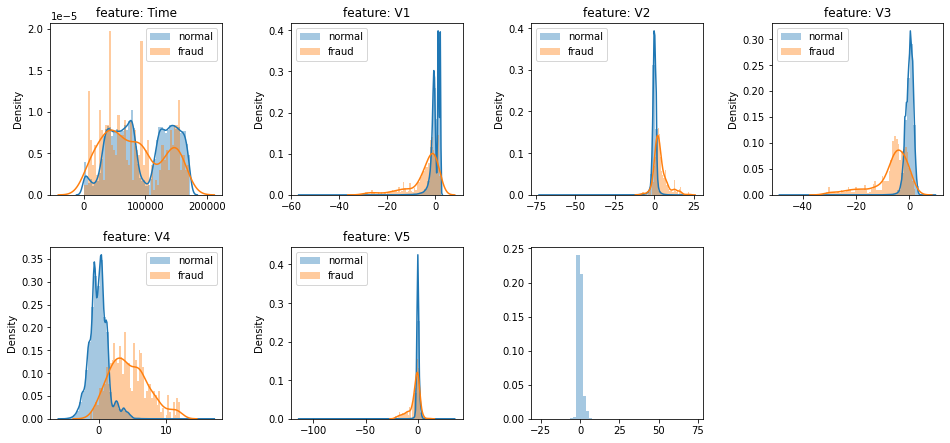

In [ ]:
from matplotlib.gridspec import GridSpec

# Plot a univariate distribution of the features
fig = plt.figure(figsize=(16,8*4))
gs = GridSpec(8, 4, wspace=0.4, hspace=0.3, figure=fig)
for i, feature_name in enumerate(list(data)[:-1]):
    ax = fig.add_subplot(gs[i])
    sns.distplot(data[feature_name][data["Class"] == 0], label=["normal"], bins=50)
    sns.distplot(data[feature_name][data["Class"] == 1], label=["fraud"], bins=50)
    plt.legend()
    ax.set_xlabel('')    
    ax.set_title('feature: ' + str(feature_name))
plt.show()

<a name="3"></a>
## 3. Preparing data

We'll divide the data into three datasets:

1. **Training set** -- to compute the mean and standard deviation of the features: 60% of `normal(0)` transactions.
2. **Dev set** -- to tune model parameters: 20% of `normal(0)` and 50% of `fraud(1)` transactions.
3. **Test set** -- to check the model: 20% of `normal(0)` and 50% of `fraud(1)` transactions.

In [ ]:
from sklearn.model_selection import train_test_split

def split_data(data, test_size=0.1):
    # Separate classes
    data_0 = data.loc[data["Class"] == 0]
    data_1 = data.loc[data["Class"] == 1] 

    # Get 60% of the normal transaction to compute the mean and standard deviation of the features
    train, data_0_remainder = train_test_split(data_0, test_size=test_size, random_state=1)

    # Split the remainder of the normal transaction for the dev and test sets
    dev_0, test_0 = train_test_split(data_0_remainder, test_size=0.5, random_state=1)

    # Split fraud transaction for the dev and test sets
    dev_1, test_1 = train_test_split(data_1, test_size=0.5, random_state=1)

    # Concatenate and shuffle dev and test data of `0` and `1` classes
    dev = pd.concat([dev_0, dev_1]).sample(frac=1)
    test = pd.concat([test_0, test_1]).sample(frac=1)

    # Display some useful information
    print("Shape of the training set:", train.shape)
    print("Number of fraud transactions in the training set:", train["Class"].sum())
    print()
    print("Shape of the development set:", dev.shape)
    print("Number of fraud transactions in the development set:", dev["Class"].sum())
    print()
    print("Shape of the test set:", test.shape)
    print("Number of fraud transactions in the test set:", test["Class"].sum())

    return train, dev, test

In [ ]:
train, dev, test = split_data(data)

Shape of the training set: (21697, 31)
Number of fraud transactions in the training set: 0

Shape of the development set: (1451, 31)
Number of fraud transactions in the development set: 246

Shape of the test set: (1452, 31)
Number of fraud transactions in the test set: 246


<a name="4"></a>
## 4. Anomaly detection using univariate approach

Recall the algorithm:
1. Choose $n$ features.
2. Fit distribution parameters $\mu_{1}, \mu_{2}, ..., \mu_{n}, \sigma_{1}^2, \sigma_{2}^2, ..., \sigma_{n}^2$.
3. Compute probability $p(x)$.
4. Flag anomaly if $p(x) < \varepsilon$.

<a name="4-1"></a>
### 4.1. Selecting features

In [ ]:
# At first, let's try all the features (except `userId` and `Time`)
selected_features = list(data)[1:-1]

print(selected_features)

['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']


<a name="4-2"></a>
### 4.2. Compute $\mu$ and $\sigma$

In [ ]:
# Obtain distribution parameters
mu = train[selected_features].mean()
sigma = train[selected_features].std()

In [ ]:
# For the convenience of display

def get_df(x, cols):
    if len(x.shape) == 1:
        x = np.expand_dims(x, axis=1)
    x = np.transpose(x)
    x = pd.DataFrame(data=x, columns=cols)
    return x

In [ ]:
# Display mu as a dataframe
print("Mean:")
mu_df = get_df(mu, selected_features)
mu_df.head()

Mean:


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,0.044911,-0.011902,0.016531,-0.011637,0.011371,0.010524,0.010009,0.002664,-0.000384,0.006421,-0.002079,0.01194,0.001474,0.010084,0.007017,0.002012,0.011101,0.003427,0.002776,-0.001181,0.000342,0.004187,0.001024,0.000614,-0.002604,-0.001183,0.001162,0.002489,86.928821


In [ ]:
# Display sigma as a dataframe
print("Sigma:")
sigma_df = get_df(sigma, selected_features)
sigma_df.head()

Sigma:


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,1.866268,1.557646,1.436896,1.401588,1.3205,1.325074,1.131414,1.100082,1.083407,1.015268,1.007126,0.949295,0.987576,0.884707,0.913444,0.84101,0.741222,0.825954,0.820848,0.706929,0.670899,0.720156,0.564036,0.6079,0.514314,0.477836,0.395205,0.292471,227.136392


<a name="4-3"></a>
### 4.3. Compute probability $p(x)$

Please review [numpy.prod](https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.prod.html).

In [ ]:
# Implement probability function using broadcasting and np.prod()
def compute_prob(x, mu, sigma):
    return np.prod(1. / (np.sqrt(2*np.pi) * sigma) * np.exp(-(x - mu)**2 / (2 * sigma**2)), axis=1)

In [ ]:
# Compute probabilities for the dev set
dev_probs = compute_prob(dev[selected_features], mu, sigma)
dev_probs.head()

21106    1.795344e-16
10586    8.204782e-19
18255    1.520067e-20
10625    1.358518e-31
4155     0.000000e+00
dtype: float64

<a name="4-4"></a>
### 4.4. Tuning $\varepsilon$

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

# Calculate predictions
def make_prediction(probs, eps):
    p = probs.copy()
    p[probs >= eps] = 0
    p[probs < eps] = 1
    return p

# Display metrics for the predictions preformance
def display_metrics(y_true, y_pred):
    print("F1 score = {:.4f}".format(f1_score(y_true, y_pred)))
    print("Precision: {:.4f}".format(precision_score(y_true, y_pred)))
    print("Recall: {:.4f}".format(recall_score(y_true, y_pred)))
    print("Accuracy: {:.4f}".format(accuracy_score(y_true, y_pred)))

In [ ]:
# Implement epsilon tuning function
def find_best_epsilon(dev, dev_probs, epsilons):
    # Select an epsilon value
    f1_list = []
    for eps in sorted(epsilons, reverse=True):

        # Compute probabilities for the dev set
        dev_pred = make_prediction(dev_probs, eps)

        # Store F1 score    
        f1_list.append(f1_score(dev["Class"], dev_pred))

        # Display metrics
        print("Epsilon = {}".format(eps))
        display_metrics(dev["Class"], dev_pred)
        print()

    # Plot F1 score for different epsilon values
    plt.plot(np.arange(len(epsilons)), f1_list)        
        
    # Find the best epsilon value (based on F1 score)
    print("===================================")
    print()
    best_epsilon = epsilons[np.argmax(f1_list)]
    dev_pred = make_prediction(dev_probs, best_epsilon)
    print("BEST CASE:")
    print("Epsilon = {}".format(best_epsilon))
    display_metrics(dev["Class"], dev_pred)    
    
    return best_epsilon    

Epsilon = 1e-10
F1 score = 0.2899
Precision: 0.1695
Recall: 1.0000
Accuracy: 0.1695

Epsilon = 1.0000000000000001e-11
F1 score = 0.2899
Precision: 0.1695
Recall: 1.0000
Accuracy: 0.1695

Epsilon = 1.0000000000000002e-12
F1 score = 0.2899
Precision: 0.1695
Recall: 1.0000
Accuracy: 0.1695

Epsilon = 1.0000000000000002e-13
F1 score = 0.2899
Precision: 0.1695
Recall: 1.0000
Accuracy: 0.1695

Epsilon = 1.0000000000000002e-14
F1 score = 0.3090
Precision: 0.1828
Recall: 1.0000
Accuracy: 0.2419

Epsilon = 1e-15
F1 score = 0.3645
Precision: 0.2237
Recall: 0.9837
Accuracy: 0.4183

Epsilon = 1.0000000000000001e-16
F1 score = 0.4327
Precision: 0.2787
Recall: 0.9675
Accuracy: 0.5700

Epsilon = 1e-17
F1 score = 0.5098
Precision: 0.3482
Recall: 0.9512
Accuracy: 0.6899

Epsilon = 1e-18
F1 score = 0.5884
Precision: 0.4267
Recall: 0.9472
Accuracy: 0.7753

Epsilon = 1.0000000000000001e-19
F1 score = 0.6543
Precision: 0.5044
Recall: 0.9309
Accuracy: 0.8332

Epsilon = 1.0000000000000001e-20
F1 score = 0.70

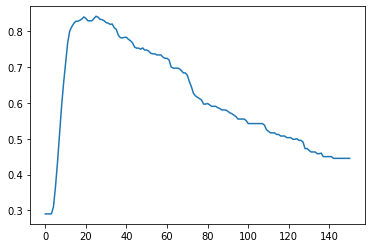

In [ ]:
# Set some epsilon values for the tuning process
epsilons = [1e-10]
for i in range(150):
    epsilons.append(epsilons[i] / 10)

# Get the best epsilon value
best_epsilon = find_best_epsilon(dev, dev_probs, epsilons)   

<a name="4-5"></a>
### 4.5. Make predictions for the test set

In [ ]:
# Compute probabilities for the test set
test_probs = compute_prob(test[selected_features], mu, sigma)
test_probs.head()

10132    1.127817e-17
21023    1.080522e-17
22949    2.008980e-18
6202     6.261358e-16
11802    1.236569e-14
dtype: float64

In [ ]:
# Measuring perfomance using the best epsilon value
test_pred = make_prediction(test_probs, best_epsilon)
print("Test set:")
print("Epsilon = {}".format(best_epsilon))
display_metrics(test["Class"], test_pred)

Test set:
Epsilon = 1.0000000000000004e-35
F1 score = 0.8577
Precision: 0.8836
Recall: 0.8333
Accuracy: 0.9532


<a name="5"></a>
## 5. Anomaly detection using multivariate Gaussian distribution

We'll use the same features as in the previous section.

Recall the algorithm:
1. Fit model $p(x)$ by setting $\mu$ and $\Sigma$.
2. Given a new example $x$, compute $p(x;\mu,\Sigma)$.
3. Flag anomaly if $p(x) < \varepsilon$.

<a name="5-1"></a>
### 5.1. Compute $\mu$ and $\Sigma$

In [ ]:
# Calculate the mean and covariation matrix for the training set
mu_multi = np.mean(train[selected_features], axis=0)
sigma_multi = np.cov(train[selected_features].T)

# Display mu as a dataframe
print("Mean:")
mu_multi_df = get_df(mu_multi, selected_features)
mu_multi_df.head()

Mean:


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,0.044911,-0.011902,0.016531,-0.011637,0.011371,0.010524,0.010009,0.002664,-0.000384,0.006421,-0.002079,0.01194,0.001474,0.010084,0.007017,0.002012,0.011101,0.003427,0.002776,-0.001181,0.000342,0.004187,0.001024,0.000614,-0.002604,-0.001183,0.001162,0.002489,86.928821


In [ ]:
# Display sigma as a dataframe
print("Sigma:")
sigma_multi_df = get_df(sigma_multi, selected_features)
sigma_multi_df.head()

Sigma:


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,3.482958,0.028349,-0.267478,0.078664,-0.161532,0.001300,-0.152672,0.000348,0.006466,-0.049118,0.019385,-0.083054,0.013035,-0.036435,0.007034,-0.041668,-0.104519,-0.047590,-0.005939,0.026810,0.013310,-0.016715,-0.006673,0.010988,0.017310,0.001754,0.028140,0.010226,-86.706907
1,0.028349,2.426262,0.101515,0.034606,0.064945,0.017309,0.198344,-0.044147,0.009641,0.023841,-0.026550,0.051458,0.005793,0.055882,-0.002405,0.048786,0.049107,0.030252,0.000999,0.015806,0.000483,-0.009106,-0.030518,-0.001005,-0.012860,0.001558,0.007711,0.022171,-182.368971
2,-0.267478,0.101515,2.064669,0.086073,-0.150301,-0.024344,-0.166007,0.038257,-0.043628,-0.123597,0.062856,-0.106095,-0.002606,-0.085303,0.009747,-0.069328,-0.138637,-0.051536,0.015619,0.021630,0.013990,-0.012731,-0.002715,-0.000551,0.016764,0.006672,0.020957,0.001383,-65.790755
3,0.078664,0.034606,0.086073,1.964449,0.040234,0.006922,0.060667,-0.008075,0.022994,0.086176,-0.037384,0.069404,0.003940,0.052407,-0.009428,0.049944,0.083834,0.036443,-0.015458,-0.012492,0.001273,0.004000,0.016950,-0.012331,0.002557,-0.000533,0.007579,-0.008198,24.410936
4,-0.161532,0.064945,-0.150301,0.040234,1.743721,0.035527,-0.070430,0.021358,-0.015015,-0.067568,0.026635,-0.066018,0.002870,-0.034724,-0.004995,-0.031613,-0.082293,-0.047674,0.007163,-0.010438,-0.002475,-0.008081,-0.008561,-0.000875,0.005552,0.003402,0.029553,-0.000890,-112.967947


<a name="5-2"></a>
### 5.2. Implement $p(x;\mu,\Sigma)$

Please review [scipy.stats.multivariate_normal](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.multivariate_normal.html).

In [ ]:
from scipy.stats import multivariate_normal

# Implement probability function
def compute_prob_multi(x, mu, sigma):
    return multivariate_normal.pdf(x, mean=mu, cov=sigma)

# Compute probabilities for the dev set
dev_probs_multi = compute_prob_multi(dev[selected_features], mu_multi, sigma_multi)
dev_probs_multi[:10]

array([1.48819323e-015, 8.78377419e-018, 1.70857641e-019, 1.76241095e-097,
       0.00000000e+000, 1.78658479e-015, 3.06839663e-219, 4.12309805e-014,
       6.27225916e-014, 1.25838335e-166])

<a name="5-3"></a>
### 5.3. Tuning $\varepsilon$

Epsilon = 1e-10
F1 score = 0.2899
Precision: 0.1695
Recall: 1.0000
Accuracy: 0.1695

Epsilon = 1.0000000000000001e-11
F1 score = 0.2899
Precision: 0.1695
Recall: 1.0000
Accuracy: 0.1695

Epsilon = 1.0000000000000002e-12
F1 score = 0.2899
Precision: 0.1695
Recall: 1.0000
Accuracy: 0.1695

Epsilon = 1.0000000000000002e-13
F1 score = 0.3048
Precision: 0.1798
Recall: 1.0000
Accuracy: 0.2267

Epsilon = 1.0000000000000002e-14
F1 score = 0.3601
Precision: 0.2204
Recall: 0.9837
Accuracy: 0.4073

Epsilon = 1e-15
F1 score = 0.4357
Precision: 0.2808
Recall: 0.9715
Accuracy: 0.5734

Epsilon = 1.0000000000000001e-16
F1 score = 0.5125
Precision: 0.3502
Recall: 0.9553
Accuracy: 0.6919

Epsilon = 1e-17
F1 score = 0.5881
Precision: 0.4273
Recall: 0.9431
Accuracy: 0.7760

Epsilon = 1e-18
F1 score = 0.6657
Precision: 0.5181
Recall: 0.9309
Accuracy: 0.8415

Epsilon = 1.0000000000000001e-19
F1 score = 0.7141
Precision: 0.5840
Recall: 0.9187
Accuracy: 0.8753

Epsilon = 1.0000000000000001e-20
F1 score = 0.76

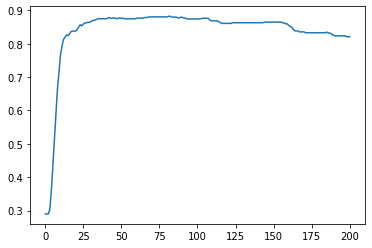

In [ ]:
# Set some epsilon values for the tuning process
epsilons = [1e-10]
for i in range(200):
    epsilons.append(epsilons[i] / 10)

# Get the best epsilon value
best_epsilon_multi= find_best_epsilon(dev, dev_probs_multi, epsilons)  

<a name="5-4"></a>
### 5.4. Make predictions for the test set

In [ ]:
# Compute probabilities for the test set
test_probs_multi = compute_prob_multi(test[selected_features], mu_multi, sigma_multi)
test_probs_multi[:10]

array([1.28796450e-16, 3.23667793e-16, 6.43835855e-17, 6.05169929e-15,
       9.10530685e-14, 8.65246968e-21, 1.02238207e-13, 1.56792931e-15,
       7.96251645e-16, 8.86750846e-14])

In [ ]:
# Measuring perfomance using the best epsilon value
test_pred_multi = make_prediction(test_probs_multi, best_epsilon_multi)
print("Test set:")
print("Epsilon = {}".format(best_epsilon_multi))
display_metrics(test["Class"], test_pred_multi)

Test set:
Epsilon = 1.0000000000000007e-91
F1 score = 0.8756
Precision: 0.9657
Recall: 0.8008
Accuracy: 0.9614


<a name="6"></a>
## 6. LightGBM approach

For comparison, let's build LightGBM classifier. Here we'll use the code from the LAB 7 with minor changes.

**Notice** that now we are using `scoring="f1"` for GridSearchCV, not an accuracy.

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.metrics import f1_score


def train_tree_model(X, y, model, params):
    """
    Train a tree-based model using GridSearchCV.

    Args:
        X (pd.DataFrame): input feature examples, size (n_examples, n_features)
        y (pd.Series): labels, size (n_examples,)
        model (sklearn, xgboost or lightgbm): a tree-based model        
        params (dict): GridSearchCV's parameters
    Returns:
        model (sklearn, xgboost or lightgbm): a trained tree-based model
    """    
    
    # Split the data
    X_train, X_dev, y_train, y_dev = train_test_split(X, y, test_size=0.3, stratify=y, random_state=1)
       
    # Display the current grid of parameters
    print("PARAMETER GRID:")
    print(f"(number of grid elements: {len(ParameterGrid(params))})")
    print(*list(ParameterGrid(params))[:10], sep="\n")
    print("...........................................\n")

    # Set a GridSearch model
    grid_model = GridSearchCV(model, params, cv=5, scoring='f1')

    # Train the GridSearch model
    grid_model.fit(X_train, y_train)

    # Display the best estimator, score and parameters
    print("BEST ESTIMATOR:")
    print(f"{grid_model.best_estimator_}\n")
    print(f"Mean cross-validated score of the best estimator: {grid_model.best_score_:.3f}\n")
    print(f"Best parameters: {grid_model.best_params_}\n")

    # Get the best classifier
    model = grid_model.best_estimator_        
     
    # Obtain and display test error
    y_dev_pred = model.predict(X_dev)
    print(f"Dev F1 score: {f1_score(y_dev, y_dev_pred):.3f}\n")
     
    # Display feature importance
    print("FEATURE IMPORTANCE:")
    feature_names = list(X)
    feature_importances = model.feature_importances_

    # Transform LightGBM's number of times the feature is used in a model into a weighting factor
    if max(feature_importances) > 1:
        feature_importances = feature_importances / sum(feature_importances)
    
    for name, value in sorted(zip(feature_names, feature_importances), key=lambda x: x[1], reverse=True):
        print(f"{name}: {value:.3f}")
    print()

    # Plot feature importance
    fig = plt.figure(figsize=(10,4))
    plt.bar(range(len(feature_importances)), feature_importances, tick_label=feature_names)
    plt.show()    
    
    return model

In [ ]:
from lightgbm import LGBMClassifier

# Instantiate a model
lgbm_model = LGBMClassifier()

# Set a parameters grid for a GridSearchCV
params = {'n_estimators': [50, 100],
          'learning_rate': np.linspace(0.05,0.25,5),
          'num_leaves': [31],
          'min_data_in_leaf': [30],
          'max_depth': range(5,7)}

# Train the model
lgbm_model = train_tree_model(data[selected_features], data["Class"], lgbm_model, params)

PARAMETER GRID:
(number of grid elements: 20)
{'learning_rate': 0.05, 'max_depth': 5, 'min_data_in_leaf': 30, 'n_estimators': 50, 'num_leaves': 31}
{'learning_rate': 0.05, 'max_depth': 5, 'min_data_in_leaf': 30, 'n_estimators': 100, 'num_leaves': 31}
{'learning_rate': 0.05, 'max_depth': 6, 'min_data_in_leaf': 30, 'n_estimators': 50, 'num_leaves': 31}
{'learning_rate': 0.05, 'max_depth': 6, 'min_data_in_leaf': 30, 'n_estimators': 100, 'num_leaves': 31}
{'learning_rate': 0.1, 'max_depth': 5, 'min_data_in_leaf': 30, 'n_estimators': 50, 'num_leaves': 31}
{'learning_rate': 0.1, 'max_depth': 5, 'min_data_in_leaf': 30, 'n_estimators': 100, 'num_leaves': 31}
{'learning_rate': 0.1, 'max_depth': 6, 'min_data_in_leaf': 30, 'n_estimators': 50, 'num_leaves': 31}
{'learning_rate': 0.1, 'max_depth': 6, 'min_data_in_leaf': 30, 'n_estimators': 100, 'num_leaves': 31}
{'learning_rate': 0.15000000000000002, 'max_depth': 5, 'min_data_in_leaf': 30, 'n_estimators': 50, 'num_leaves': 31}
{'learning_rate': 0.1

KeyboardInterrupt: ignored

<a name="7"></a>
## 7. YOUR TURN

Use all the data, i.e., `creditcard.csv` file.  
Build, tune, and predict.

In [ ]:
from google.colab import drive
import pandas as pd

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd drive/MyDrive/Classroom/'ML-03 Machine Learning'

[Errno 2] No such file or directory: 'drive/MyDrive/Classroom/ML-03 Machine Learning'
/content/drive/MyDrive/Classroom/ML-03 Machine Learning


In [ ]:
data = pd.read_csv('creditcard.csv')
print(data.shape)
data.sample(5)

(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
134151,80670.0,-1.371948,1.548554,-0.883804,0.985817,-2.346673,0.775593,1.183529,0.944707,-0.851944,-0.890079,-1.109293,-0.215455,-0.511734,1.309392,1.350722,0.096895,0.409533,-0.030104,0.095403,-0.644234,0.183680,0.398487,0.130879,-0.275536,-0.135126,-0.281518,-0.310923,-0.287098,387.90,0
207806,136839.0,1.801637,-0.091200,-2.906274,1.158356,1.393838,-0.664658,1.345136,-0.592503,-0.427915,0.267764,-1.315177,0.427879,0.938856,0.695274,-0.292231,-0.713275,-0.492825,-0.382696,-0.148504,0.175568,0.378824,0.907232,-0.441483,0.111877,0.946570,-0.205412,-0.084142,-0.045511,185.00,0
134622,80890.0,-1.777134,0.064527,-1.755058,-0.766852,-5.997183,3.320054,7.273548,-1.386244,-0.282165,-0.808835,0.957210,0.207782,0.219536,-0.309205,-0.969888,0.770284,-0.967937,-0.100515,0.129987,-1.342102,-0.583917,0.531107,0.166189,0.223785,-0.373300,0.826195,0.648198,-0.916462,1404.74,0
124285,77243.0,-0.570620,0.498574,2.211046,0.779157,-0.241060,0.323148,-0.094736,0.474397,-0.308932,-0.181472,1.103425,-0.526728,-2.210865,0.703014,1.329974,0.158520,-0.169718,0.615548,0.281514,-0.054048,0.052959,-0.036877,-0.083550,-0.062748,0.052904,-0.355961,0.028225,-0.011799,18.99,0
22868,32478.0,-2.786444,2.498110,0.741951,-1.973974,-0.556793,-0.998569,0.717969,-0.259257,2.284888,3.426643,1.851148,0.648751,-0.211146,-1.090596,0.031505,0.373970,-1.177541,-0.176674,-0.872984,1.571843,-0.448312,-0.300572,0.056706,0.528674,0.190914,0.672246,0.852075,0.294316,2.31,0


In [ ]:
data.groupby('Class', as_index=False).Class.agg('count').rename(columns={'Class': 'Class_value_counts'})

,Class_value_counts
0,284315
1,492


In [ ]:
data.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [ ]:
train, dev, test = split_data(data)

Shape of the training set: (255883, 31)
Number of fraud transactions in the training set: 0

Shape of the development set: (14462, 31)
Number of fraud transactions in the development set: 246

Shape of the test set: (14462, 31)
Number of fraud transactions in the test set: 246


In [ ]:
selected_features = list(data)[1:-1]

In [ ]:
def univariate_approach(train, dev, test, selected_features, epsilons=[0.01], n=150):
  """Selecting features
    Compute $\mu$ and $\sigma$
    Compute probability $p(x)$
    Tuning $\varepsilon$
    Make predictions for the test set"""
  
  mu = train[selected_features].mean()
  sigma = train[selected_features].std()
  
  dev_probs = compute_prob(dev[selected_features], mu, sigma)

  for i in range(n):
      epsilons.append(epsilons[i] / 10)

  best_epsilon = find_best_epsilon(dev, dev_probs, epsilons)

  test_probs = compute_prob(test[selected_features], mu, sigma)
  test_pred = make_prediction(test_probs, best_epsilon)


  return test_pred

Epsilon = 0.1
F1 score = 0.0335
Precision: 0.0170
Recall: 1.0000
Accuracy: 0.0170

Epsilon = 0.01
F1 score = 0.0335
Precision: 0.0170
Recall: 1.0000
Accuracy: 0.0170

Epsilon = 0.001
F1 score = 0.0335
Precision: 0.0170
Recall: 1.0000
Accuracy: 0.0170

Epsilon = 0.0001
F1 score = 0.0335
Precision: 0.0170
Recall: 1.0000
Accuracy: 0.0170

Epsilon = 1e-05
F1 score = 0.0335
Precision: 0.0170
Recall: 1.0000
Accuracy: 0.0170

Epsilon = 1.0000000000000002e-06
F1 score = 0.0335
Precision: 0.0170
Recall: 1.0000
Accuracy: 0.0170

Epsilon = 1.0000000000000002e-07
F1 score = 0.0335
Precision: 0.0170
Recall: 1.0000
Accuracy: 0.0170

Epsilon = 1.0000000000000002e-08
F1 score = 0.0335
Precision: 0.0170
Recall: 1.0000
Accuracy: 0.0170

Epsilon = 1.0000000000000003e-09
F1 score = 0.0335
Precision: 0.0170
Recall: 1.0000
Accuracy: 0.0170

Epsilon = 1.0000000000000003e-10
F1 score = 0.0335
Precision: 0.0170
Recall: 1.0000
Accuracy: 0.0170

Epsilon = 1.0000000000000003e-11
F1 score = 0.0335
Precision: 0.017

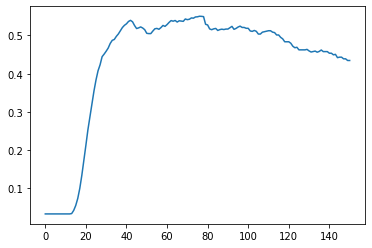

In [ ]:
test_pred_univariate_approach = univariate_approach(train, dev, test, selected_features, epsilons=[1e-1], n=150)

In [ ]:
print("Test set:")
display_metrics(test["Class"], test_pred_univariate_approach)

Test set:
F1 score = 0.5443
Precision: 0.5658
Recall: 0.5244
Accuracy: 0.9851


In [ ]:
def multivariate_normal_distribution_approach(train, dev, test, selected_features, epsilons=[1e-3], n=200):
  mu_multi = np.mean(train[selected_features], axis=0)
  sigma_multi = np.cov(train[selected_features].T)

  dev_probs_multi = compute_prob_multi(dev[selected_features], mu_multi, sigma_multi)

  for i in range(n):
      epsilons.append(epsilons[i] / 10)

  best_epsilon_multi= find_best_epsilon(dev, dev_probs_multi, epsilons)  
  
  test_probs_multi = compute_prob_multi(test[selected_features], mu_multi, sigma_multi)

  test_pred_multi = make_prediction(test_probs_multi, best_epsilon_multi)

  return test_pred_multi

Epsilon = 0.001
F1 score = 0.0335
Precision: 0.0170
Recall: 1.0000
Accuracy: 0.0170

Epsilon = 0.0001
F1 score = 0.0335
Precision: 0.0170
Recall: 1.0000
Accuracy: 0.0170

Epsilon = 1e-05
F1 score = 0.0335
Precision: 0.0170
Recall: 1.0000
Accuracy: 0.0170

Epsilon = 1.0000000000000002e-06
F1 score = 0.0335
Precision: 0.0170
Recall: 1.0000
Accuracy: 0.0170

Epsilon = 1.0000000000000002e-07
F1 score = 0.0335
Precision: 0.0170
Recall: 1.0000
Accuracy: 0.0170

Epsilon = 1.0000000000000002e-08
F1 score = 0.0335
Precision: 0.0170
Recall: 1.0000
Accuracy: 0.0170

Epsilon = 1.0000000000000003e-09
F1 score = 0.0335
Precision: 0.0170
Recall: 1.0000
Accuracy: 0.0170

Epsilon = 1.0000000000000003e-10
F1 score = 0.0335
Precision: 0.0170
Recall: 1.0000
Accuracy: 0.0170

Epsilon = 1.0000000000000003e-11
F1 score = 0.0335
Precision: 0.0170
Recall: 1.0000
Accuracy: 0.0170

Epsilon = 1.0000000000000002e-12
F1 score = 0.0335
Precision: 0.0170
Recall: 1.0000
Accuracy: 0.0170

Epsilon = 1.0000000000000002e-

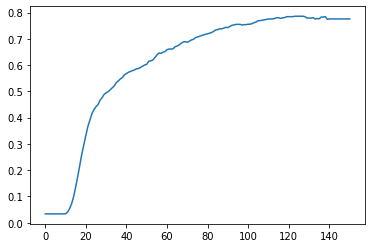

In [ ]:
test_pred_multivariate_normal_distribution_approach = multivariate_normal_distribution_approach(train, dev, test, selected_features, epsilons=[1e-3], n=150)

In [ ]:
print("Test set:")
display_metrics(test["Class"], test_pred_multivariate_normal_distribution_approach)

Test set:
F1 score = 0.7885
Precision: 0.7967
Recall: 0.7805
Accuracy: 0.9929


PARAMETER GRID:
(number of grid elements: 20)
{'learning_rate': 0.05, 'max_depth': 5, 'min_data_in_leaf': 30, 'n_estimators': 50, 'num_leaves': 31}
{'learning_rate': 0.05, 'max_depth': 5, 'min_data_in_leaf': 30, 'n_estimators': 100, 'num_leaves': 31}
{'learning_rate': 0.05, 'max_depth': 6, 'min_data_in_leaf': 30, 'n_estimators': 50, 'num_leaves': 31}
{'learning_rate': 0.05, 'max_depth': 6, 'min_data_in_leaf': 30, 'n_estimators': 100, 'num_leaves': 31}
{'learning_rate': 0.1, 'max_depth': 5, 'min_data_in_leaf': 30, 'n_estimators': 50, 'num_leaves': 31}
{'learning_rate': 0.1, 'max_depth': 5, 'min_data_in_leaf': 30, 'n_estimators': 100, 'num_leaves': 31}
{'learning_rate': 0.1, 'max_depth': 6, 'min_data_in_leaf': 30, 'n_estimators': 50, 'num_leaves': 31}
{'learning_rate': 0.1, 'max_depth': 6, 'min_data_in_leaf': 30, 'n_estimators': 100, 'num_leaves': 31}
{'learning_rate': 0.15000000000000002, 'max_depth': 5, 'min_data_in_leaf': 30, 'n_estimators': 50, 'num_leaves': 31}
{'learning_rate': 0.1

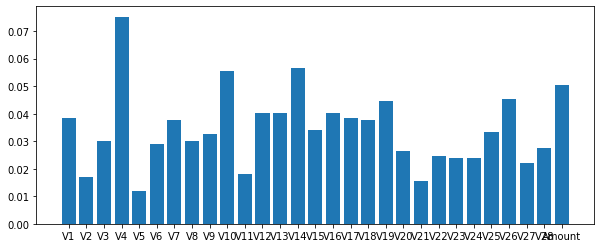

In [ ]:
from lightgbm import LGBMClassifier

# Instantiate a model
lgbm_model = LGBMClassifier()

# Set a parameters grid for a GridSearchCV
params = {'n_estimators': [50, 100],
          'learning_rate': np.linspace(0.05,0.25,5),
          'num_leaves': [31],
          'min_data_in_leaf': [30],
          'max_depth': range(5,7)}

# Train the model
lgbm_model = train_tree_model(data[selected_features], data["Class"], lgbm_model, params)